In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
import tweepy
import os
import json
import time
from datetime import datetime
from tqdm.auto import tqdm, trange
import requests
import glob
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from features import prepare_entry, get_transformer, merge_entries
from utills import chunker, cartesian_product, extract_twitter_username
import fasttext

In [3]:
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from train_validate_hpc import generate_doc_pairs
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, average_precision_score

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
from scipy.optimize import linear_sum_assignment

In [5]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib notebook

In [7]:
import warnings
warnings.filterwarnings('ignore')

Load Data
===

In [8]:
def preprocess_twitter(text):
    regex_username = r'(^|[^@\w])@(\w{1,15})\b'
    regex_hashtag = r'\#([A-Za-z]+[A-Za-z0-9-_]+)'
    regex_url = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(regex_url + '|' + regex_username + '|' + regex_hashtag, '', text)

def sanitize(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)
        

In [9]:
fmodel = fasttext.load_model('../temp_data/lid.176.bin')

In [10]:
def load_english_text(file):
    with open(file, 'r') as f:
        res = ('\n'.join([json.loads(l) for l in f])).split('\n')
        res = [t for t in res if len(t) > 0]
        preds = np.array(fmodel.predict(res)[0])[:, 0]
        return [res[i] for i in range(len(res)) if preds[i] == '__label__en']

def load_dataset(reddit_to_twitter, twitter_base_path, reddit_base_path, reddit_base_path2, chars_per_chunk, max_per_author):
    reddit_docs = []
    twitter_docs = []

    for r, t in tqdm(reddit_to_twitter.items()):
        chunk = ''
        chunks = []
        text = ''
        if os.path.exists(reddit_base_path + r + '.jsonl'):
            text = '\n'.join(load_english_text(reddit_base_path + r + '.jsonl'))
        if reddit_base_path2 and os.path.exists(reddit_base_path2 + r + '.jsonl'):
            text += '\n' + '\n'.join(load_english_text(reddit_base_path2 + r + '.jsonl'))
        for l in text.split('\n'):
            l = sanitize(l)
            chunk += l + '\n'
            if len(chunk) > chars_per_chunk:
                chunks.append(chunk)
                chunk = ''
        reddit_docs.append(chunks[:max_per_author])

        chunk = ''
        chunks = []
        text = '\n'.join(load_english_text(twitter_base_path + t + '.jsonl'))
        for l in text.split('\n'):
            l = preprocess_twitter(sanitize(l))
            chunk += l + '\n'
            if len(chunk) > chars_per_chunk:
                chunks.append(chunk)
                chunk = ''
        twitter_docs.append(chunks[:max_per_author])
    return reddit_docs, twitter_docs

def get_manual_dataset(chars_per_chunk, max_per_author):
    TWITTER_DATA_DIR = '../data/twitter_reddit/manual_dataset/twitter/'
    REDDIT_DATA_DIR = '../data/twitter_reddit/manual_dataset/reddit/'
    REDDIT_SUB_DATA_DIR = '../data/twitter_reddit/manual_dataset/reddit_submissions/'
    DATA_PATH = '../data/twitter_reddit/'
    with open(DATA_PATH + 'to_collect.p', 'rb') as f:
        to_collect, _, _, _, _ = pickle.load(f)

    reddit_usernames = [d[0] for d in to_collect]
    twitter_usernames = [d[1] for d in to_collect]


    saved_twitter_users = [re.search('/twitter/(.*).jsonl', f).group(1) for f in glob.glob(TWITTER_DATA_DIR + '*.jsonl')]
    saved_reddit_users = np.union1d(
        [re.search('/reddit/(.*).jsonl', f).group(1) for f in glob.glob(REDDIT_DATA_DIR + '*.jsonl')],
        [re.search('/reddit_submissions/(.*).jsonl', f).group(1) for f in glob.glob(REDDIT_SUB_DATA_DIR + '*.jsonl')]
    )
    
    
    
    reddit_to_twitter = {
        reddit_usernames[i]:twitter_usernames[i] 
        for i in range(len(reddit_usernames)) 
        if reddit_usernames[i] in saved_reddit_users and twitter_usernames[i] in saved_twitter_users}
    
    reddit_docs, twitter_docs = load_dataset(reddit_to_twitter, TWITTER_DATA_DIR, REDDIT_DATA_DIR, REDDIT_SUB_DATA_DIR, chars_per_chunk, max_per_author)
    return reddit_to_twitter, reddit_usernames, twitter_usernames, reddit_docs, twitter_docs

def get_r_twitter_dataset(chars_per_chunk, max_per_author):
    with open('../data/twitter_reddit/r_twitterfollowers.p', 'rb') as f:
        (data, data_comments) = pickle.load(f)

    reddit_usernames = []
    twitter_usernames = []
    for d in data:
        twitter = extract_twitter_username(d['url'])
        if twitter:
            reddit_usernames.append(d['author'])
            twitter_usernames.append(twitter)

    for d in data_comments:
        twitter = extract_twitter_username(d['body'])
        if twitter:
            reddit_usernames.append(d['author'])
            twitter_usernames.append(twitter)


    saved_twitter_users = [re.search('/twitter/(.*).jsonl', f).group(1) for f in glob.glob('../data/twitter_reddit/twitterfollowers/twitter/*.jsonl')]
    saved_reddit_users = [re.search('/reddit/(.*).jsonl', f).group(1) for f in glob.glob('../data/twitter_reddit/twitterfollowers/reddit/*.jsonl')]

    reddit_to_twitter = {
        reddit_usernames[i]:twitter_usernames[i] 
        for i in range(len(reddit_usernames)) 
        if reddit_usernames[i] in saved_reddit_users and twitter_usernames[i] in saved_twitter_users}
    
    
    reddit_base_path = '../data/twitter_reddit/twitterfollowers/reddit/'
    twitter_base_path = '../data/twitter_reddit/twitterfollowers/twitter/'

    reddit_docs, twitter_docs = load_dataset(reddit_to_twitter, twitter_base_path, reddit_base_path, None, chars_per_chunk, max_per_author)
    return reddit_to_twitter, reddit_usernames, twitter_usernames, reddit_docs, twitter_docs

def compute_user_level_performance(r_usernames, t_usernames, r_user_docs, t_user_docs, clf, transformer, primary_scaler, secondary_scaler, negative_twitter_sample_order=None):
    n_user_pairs = len(t_usernames)
    preds = []
    labels = []
    # Positive samples
    for i in trange(n_user_pairs):
        X_1 = primary_scaler.transform(transformer.transform(r_user_docs[i]).todense())
        X_2 = primary_scaler.transform(transformer.transform(t_user_docs[i]).todense())
        idx_pairs = cartesian_product(range(len(X_1)), range(len(X_2)))
        X_diff = secondary_scaler.transform(np.abs(X_1[idx_pairs[:, 0], :] - X_2[idx_pairs[:, 1], :]))
        p = clf.predict_proba(X_diff)[:, 1]
        preds.append(p)
        labels.append(1)

    # Negative samples
    shuffled_order = np.random.permutation(len(t_usernames))
    for i in trange(n_user_pairs):
        if negative_twitter_sample_order is not None:           
            X_1 = primary_scaler.transform(transformer.transform(r_user_docs[negative_twitter_sample_order[i][0]]).todense())
            X_2 = primary_scaler.transform(transformer.transform(t_user_docs[negative_twitter_sample_order[i][1]]).todense())
        else:
            X_1 = primary_scaler.transform(transformer.transform(r_user_docs[i]).todense())
            X_2 = primary_scaler.transform(transformer.transform(t_user_docs[shuffled_order[i]]).todense())
            
        idx_pairs = cartesian_product(range(len(X_1)), range(len(X_2)))
        X_diff = secondary_scaler.transform(np.abs(X_1[idx_pairs[:, 0], :] - X_2[idx_pairs[:, 1], :]))
        p = clf.predict_proba(X_diff)[:, 1]
        preds.append(p)
        labels.append(0)
        
    return preds, labels

In [ ]:
reddit_to_twitter_1, reddit_usernames_1, twitter_usernames_1, reddit_1, twitter_1 = get_r_twitter_dataset(chars_per_chunk=5000, max_per_author=50)
reddit_to_twitter_2, reddit_usernames_2, twitter_usernames_2, reddit_2, twitter_2 = get_manual_dataset(chars_per_chunk=5000, max_per_author=50)

In [ ]:
reddit_docs = reddit_1 + reddit_2
twitter_docs = twitter_1 + twitter_2
reddit_usernames = reddit_usernames_1 + reddit_usernames_2
twitter_usernames = twitter_usernames_1 + twitter_usernames_2

reddit_to_twitter = {}
for k, v in reddit_to_twitter_1.items():
    reddit_to_twitter[k] = v

for k, v in reddit_to_twitter_2.items():
    reddit_to_twitter[k] = v
assert len(reddit_docs) == len(twitter_docs)

In [11]:
len(reddit_1), len(reddit_2), len(reddit_docs), len(twitter_docs)

(277, 799, 1076, 1076)

Preprocess
==

In [12]:
reddit_docs_preprocessed = [
        [prepare_entry(c, mode='accurate', tokenizer='casual') for c in chunks]
    for chunks in tqdm(reddit_docs)]

twitter_docs_preprocessed = [
        [prepare_entry(c, mode='accurate', tokenizer='casual') for c in chunks]
    for chunks in tqdm(twitter_docs)]

In [13]:
with open('../temp_data/twitter_reddit/twitter_reddit_preprocessed_data_manual_dataset.p', 'wb') as f:
    pickle.dump((
        reddit_usernames,
        twitter_usernames,
        reddit_to_twitter,
        reddit_docs_preprocessed,
        twitter_docs_preprocessed
    ), f)

In [8]:
with open('../temp_data/twitter_reddit/twitter_reddit_preprocessed_data_manual_dataset.p', 'rb') as f:
    (
        reddit_usernames,
        twitter_usernames,
        reddit_to_twitter,
        reddit_docs_preprocessed,
        twitter_docs_preprocessed
    ) = pickle.load(f)

In [9]:
reddit_char_lengths = []
reddit_token_lengths = []
for d in reddit_docs_preprocessed:
    reddit_char_lengths.extend([len(chunk['preprocessed']) for chunk in d])
    reddit_token_lengths.extend([len(chunk['tokens']) for chunk in d])
    
twitter_char_lengths = []
twitter_token_lengths = []
for d in twitter_docs_preprocessed:
    twitter_char_lengths.extend([len(chunk['preprocessed']) for chunk in d])
    twitter_token_lengths.extend([len(chunk['tokens']) for chunk in d])

In [21]:
print('Reddit char lengths:', np.mean(reddit_char_lengths))
print('Reddit token lengths:', np.mean(reddit_token_lengths))

print('Twitter char lengths:', np.mean(twitter_char_lengths))
print('Twitter token lengths:', np.mean(twitter_token_lengths))

print('All token lengths:', np.mean(reddit_token_lengths + twitter_token_lengths))

Reddit char lengths: 5119.340892521393
Reddit token lengths: 1045.744215494417
Twitter char lengths: 5061.004755500048
Twitter token lengths: 1064.9550869439909
All token lengths: 1054.275368501888


Train Model
===

In [10]:
reddit_usernames_ordered = []
twitter_usernames_ordered = []
for r, t in reddit_to_twitter.items():
    reddit_usernames_ordered.append(r)
    twitter_usernames_ordered.append(t)

reddit_usernames_ordered = np.array(reddit_usernames_ordered)
twitter_usernames_ordered = np.array(twitter_usernames_ordered)

twitter_docs_preprocessed = np.array(twitter_docs_preprocessed)
reddit_docs_preprocessed = np.array(reddit_docs_preprocessed)



In [11]:
idxs = [i for i in range(len(reddit_usernames_ordered)) if len(twitter_docs_preprocessed[i]) > 0 and len(reddit_docs_preprocessed[i]) > 0]

In [12]:
len(idxs), len(twitter_docs_preprocessed)

(1015, 1076)

In [13]:
train_user_index, test_user_index = train_test_split(idxs, test_size=0.33, random_state=0)

r_usernames = reddit_usernames_ordered[train_user_index]
t_usernames = twitter_usernames_ordered[train_user_index]

r_user_docs = reddit_docs_preprocessed[train_user_index]
t_user_docs  = twitter_docs_preprocessed[train_user_index]

In [14]:
print('Train Set Size:', len(train_user_index))
print('Test Set Size:', len(test_user_index))

Train Set Size: 680
Test Set Size: 335


Ensure similar topics for negative samples
----

In [15]:
n_features = 5000 # number of most common words
n_topics = 150 # number of topics
n_top_words = 60 # number of characteristic words per topic (viz purposes only)
max_df = 0.7 # maximum document frequency
min_df = 50 # minimum document frequency

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        
ALLOWED_POS_TAGS = set(['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRP$', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WP', 'WP$'])


def preprocess_for_topics(e):
    return [
        re.sub(r"[,.;@#?!&$]+\ *", " ", e['tokens'][i]).strip() 
    for i in range(len(e['tokens'])) if e['pos_tags'][i] in ALLOWED_POS_TAGS]

def noop(x):
    return x

def apply_topic_model(nmf, topic_transformer, docs):
    x = normalize(nmf.transform(topic_transformer.transform(map(preprocess_for_topics, docs))))
    for i in range(len(x)):
        if x[i].sum() == 0:
            x[i] += 1/len(topic_transformer.get_feature_names())
    return x


def find_best_assignment(r_docs, t_docs, nmf, transformer):

    X_topic_r = [apply_topic_model(nmf, transformer, dd).mean(axis=0) for dd in tqdm(r_docs)]
    X_topic_t = [apply_topic_model(nmf, transformer, dd).mean(axis=0) for dd in tqdm(t_docs)]
    
    same_auth_sims = np.array([cosine(X_topic_r[i], X_topic_t[i]) for i in trange(len(X_topic_r))])
    
    diff_auth_idxs = []
    for i in range(len(r_docs)):
        for j in range(i):
            diff_auth_idxs.append((i, j))
    diff_auth_idxs = np.array(diff_auth_idxs)
    
    diff_auth_sims = np.array([cosine(X_topic_r[i], X_topic_t[j]) for i, j in tqdm(diff_auth_idxs)])
    
    topic_distance_matrix = np.zeros((len(same_auth_sims), len(diff_auth_idxs)))
    for s in range(len(same_auth_sims)):
        for d in range(len(diff_auth_idxs)):
            topic_distance_matrix[s][d] = np.abs(same_auth_sims[s] - diff_auth_sims[d])

    row_ind, col_ind = linear_sum_assignment(topic_distance_matrix)
    diff_auth_idxs = diff_auth_idxs[col_ind]
    
    return diff_auth_idxs, topic_distance_matrix, same_auth_sims, diff_auth_sims[col_ind]

In [ ]:
print('Fit topic model...')
r_user_docs = reddit_docs_preprocessed[train_user_index]
t_user_docs = twitter_docs_preprocessed[train_user_index]

docs = []
for i in trange(len(r_user_docs)):
    docs.extend(list(map(preprocess_for_topics, r_user_docs[i])))
    
for i in trange(len(t_user_docs)):
    docs.extend(list(map(preprocess_for_topics, t_user_docs[i])))
    
topic_transformer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=n_features, analyzer=noop)
X = topic_transformer.fit_transform(docs)
nmf = NMF(n_components=n_topics, max_iter=50)
X = nmf.fit_transform(X)


display_topics(nmf, topic_transformer.get_feature_names(), 40)


In [22]:
with open('../temp_data/twitter_reddit/topic_model.p', 'wb') as f:
    pickle.dump((
        topic_transformer, 
        nmf
    ), f)

In [16]:
with open('../temp_data/twitter_reddit/topic_model.p', 'rb') as f:
    (
        topic_transformer, 
        nmf
    ) = pickle.load(f)
    
display_topics(nmf, topic_transformer.get_feature_names(), 40)

Topic 0:
things something way lot being other thing point make different feel someone doesn't problem say understand same makes kind agree isn't most many seems want bad much stuff mean sense person having does anything saying better important life reason seem
Topic 1:
’ s m re ll ve t been let didn haven d sure going wasn y doesn go isn won everyone couldn launch bc hasn right wouldn year thing 🏼 💓 first yep ain yeah weird years few anyone coming
Topic 2:
URL ] link onlyfans info follow check instagram here's page twitter version interested edit feedback used click discord original other help use listed picture similar example painted go pictures add sure information uk paint painting find links tank want look
Topic 3:
* telephone chain chains kubernetes word canada meaning edit ): previous upvote bonus splatoon upvoted docker several sets challenges themed pvp phrase n itself ͡ x course tank note f answers fact theme points little total form cough entire chair
Topic 4:
thanks lot fee

In [17]:
diff_auth_idxs, topic_distance_matrix, sa_sims, da_sims = find_best_assignment(r_user_docs, t_user_docs, nmf, topic_transformer)

In [18]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=sa_sims,
        name='Same Author',
    nbinsx=20
    ))
fig.add_trace(go.Histogram(
        x=da_sims,
        name='Different Author',
    nbinsx=20
    ))

In [19]:

style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=8

TEXT_WIDTH = 7.0 # Text with on a column
HALF_COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 2

In [22]:
with open('../temp_data/twitter_reddit/topic_similarities.p', 'rb') as f:
    (
        sa_sims, da_sims,
        sa_sims_test, da_sims_test
    ) = pickle.load(f)

<IPython.core.display.Javascript object>


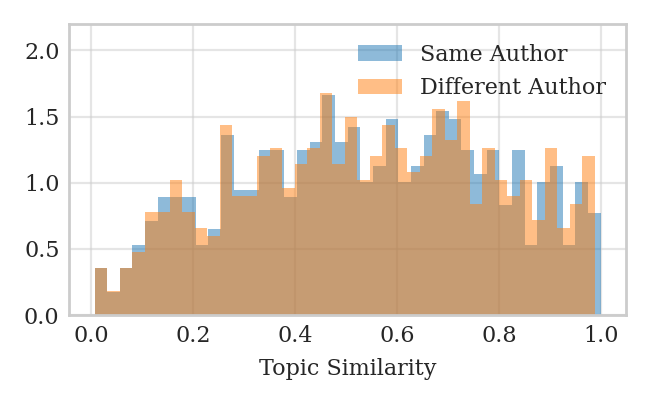

In [31]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))
# Need to take (1 - sim) because earlier we computed the cosine distance
plt.hist(1 - sa_sims, bins=40, alpha=0.5, density=True)
plt.hist(1 - da_sims, bins=40, alpha=0.5, density=True)

plt.xlabel('Topic Similarity')
plt.grid(True, alpha=0.5)
plt.ylim(0.0, 2.2)
plt.legend(labels=['Same Author','Different Author'], loc='best')
plt.tight_layout()

plt.show()


fig.savefig('../figures/plt_twitter_reddit_topics.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


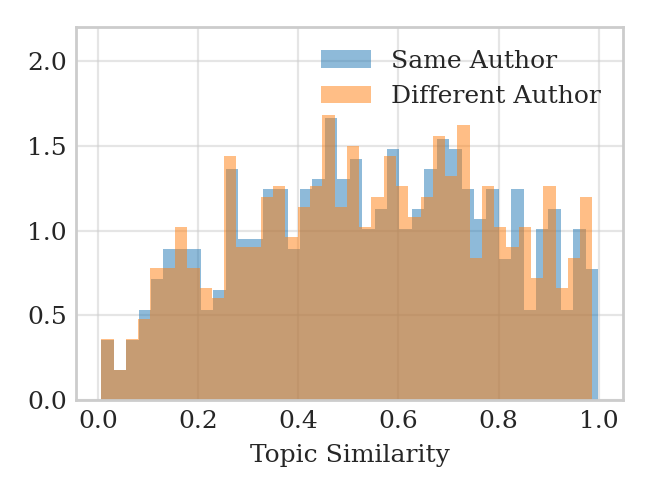

In [124]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))
# Need to take (1 - sim) because earlier we computed the cosine distance
plt.hist(1 - sa_sims, bins=40, alpha=0.5, density=True)
plt.hist(1 - da_sims, bins=40, alpha=0.5, density=True)

plt.xlabel('Topic Similarity')
plt.grid(True, alpha=0.5)
plt.ylim(0.0, 2.2)
plt.legend(labels=['Same Author','Different Author'], loc='best')
plt.tight_layout()

plt.show()


fig.savefig('../figures/plt_twitter_reddit_topics.pdf', bbox_inches='tight')

In [20]:
r_usernames_test = reddit_usernames_ordered[test_user_index]
t_usernames_test = twitter_usernames_ordered[test_user_index]
r_user_docs_test = reddit_docs_preprocessed[test_user_index]
t_user_docs_test  = twitter_docs_preprocessed[test_user_index]
diff_auth_idxs_test, topic_distance_matrix_test, sa_sims_test, da_sims_test = find_best_assignment(r_user_docs_test, t_user_docs_test, nmf, topic_transformer)


In [22]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=sa_sims_test,
        name='Same Author',
    nbinsx=20
    ))
fig.add_trace(go.Histogram(
        x=da_sims_test,
        name='Different Author',
    nbinsx=20
    ))

In [23]:
with open('../temp_data/twitter_reddit/topic_similarities.p', 'wb') as f:
    pickle.dump((
        sa_sims, da_sims,
        sa_sims_test, da_sims_test
    ), f)

Train Classifiers
====

In [21]:
train_docs, train_pair_idxs, train_labels = generate_doc_pairs(r_usernames, t_usernames, r_user_docs, t_user_docs, negative_twitter_sample_order=diff_auth_idxs)

In [22]:
transformer = get_transformer()
primary_scaler = StandardScaler()
XX_train = transformer.fit_transform(train_docs)
XX_train = primary_scaler.fit_transform(XX_train.todense())


batch_size = 50000
secondary_scaler = StandardScaler()
XX_diff_train = np.abs(XX_train[train_pair_idxs[:batch_size, 0], :] - XX_train[train_pair_idxs[:batch_size, 1], :])
secondary_scaler.fit_transform(XX_diff_train)


array([[-0.46801548, -0.48213625,  0.0090854 , ...,  0.16086776,
        -0.22873876, -0.03041706],
       [-0.48689472, -0.5059496 , -0.02878306, ..., -0.22512121,
        -0.22873876,  0.23557815],
       [-0.0712539 ,  0.01831978,  0.06420838, ..., -0.55766555,
        -0.22873876, -0.42940988],
       ...,
       [-0.47661199, -0.49297947,  0.02950686, ..., -0.28026249,
        -0.22873876, -0.56240748],
       [-0.07475747,  0.01390054, -0.54463761, ...,  0.02301456,
        -0.22873876, -0.56240748],
       [-0.07870046,  0.00892704,  1.7714096 , ..., -0.61111017,
        -0.22873876,  0.44837432]])

In [23]:
# Prepare test set

test_docs, test_pair_idxs, test_labels = generate_doc_pairs(r_usernames_test, t_usernames_test, r_user_docs_test, t_user_docs_test, negative_twitter_sample_order=diff_auth_idxs_test)
XX_test = primary_scaler.transform(transformer.transform(test_docs).todense())

XX_diff_test = np.abs(XX_test[test_pair_idxs[:batch_size, 0], :] - XX_test[test_pair_idxs[:batch_size, 1], :])
XX_diff_test = secondary_scaler.transform(XX_diff_test)



In [25]:
len(train_labels)

855403

In [34]:
print('Training classifier...', flush=True)
clf = SGDClassifier(loss='log', alpha=0.1)
aucs = []
num_epochs = 25
batch_size = 50000
for i in trange(num_epochs):
    print('Epoch - ', i)
    print('-' * 30)
    for j in chunker(list(range(len(train_labels))), batch_size):
        x_idxs = train_pair_idxs[j]
        y = train_labels[j]
        x = np.abs(XX_train[x_idxs[:, 0], :] - XX_train[x_idxs[:, 1], :])
        clf.partial_fit(secondary_scaler.transform(x), y, classes=[0, 1])

        probs = clf.predict_proba(XX_diff_test)[:, 1]
        fpr, tpr, thresh = roc_curve(test_labels[:XX_diff_test.shape[0]], probs)
        roc_auc = auc(fpr, tpr)
        print('AUC: ', roc_auc)
    aucs.append(roc_auc)
    

Training classifier...


Epoch -  0
------------------------------
AUC:  0.751213802122787
AUC:  0.7649598828847128
AUC:  0.7693839492587834
AUC:  0.7749704720684071
AUC:  0.7724952194092127
AUC:  0.7717993316942663
AUC:  0.7743011054892919
AUC:  0.7746674684916742
AUC:  0.7733246235170317
AUC:  0.7744768028123812
AUC:  0.7750323957994977
AUC:  0.7733141991261041
AUC:  0.7744239734140482
AUC:  0.7728813828323172
AUC:  0.7737953824810666
AUC:  0.77326681960511
AUC:  0.7744119596756325
AUC:  0.7747482275110245
Epoch -  1
------------------------------
AUC:  0.7752980313039162
AUC:  0.7746807530678601
AUC:  0.7747248674641048
AUC:  0.7761616055824568
AUC:  0.7749945139502006
AUC:  0.7746887574251498
AUC:  0.7752937514296125
AUC:  0.7756600103961573
AUC:  0.7756252656275016
AUC:  0.7753027065144027
AUC:  0.775492480686595
AUC:  0.7754081716443557
AUC:  0.7750230261719083
AUC:  0.7746008167319026
AUC:  0.7752854141576424
AUC:  0.7747918681440703
AUC:  0.7746037089281878
AUC:  0.7748473976725269
Epoch -  2
---------

AUC:  0.775609232904652
AUC:  0.7756858000800224
AUC:  0.7756336045000232
AUC:  0.7755550862525598
AUC:  0.7755802485202967
Epoch -  17
------------------------------
AUC:  0.7756043944379278
AUC:  0.775567981894768
AUC:  0.7755312716490576
AUC:  0.7756150172972224
AUC:  0.7755120906417068
AUC:  0.7754413030572528
AUC:  0.7754645110517943
AUC:  0.7755827933969396
AUC:  0.775638713459925
AUC:  0.7756538450723659
AUC:  0.7757051939607023
AUC:  0.775673972005563
AUC:  0.7756581153433615
AUC:  0.7755981554887745
AUC:  0.7756754317083923
AUC:  0.7756299952567342
AUC:  0.7755527382437326
AUC:  0.775575610122491
Epoch -  18
------------------------------
AUC:  0.7755974016290899
AUC:  0.7755566083768913
AUC:  0.7755157943175254
AUC:  0.7755926159805602
AUC:  0.7754972279218922
AUC:  0.7754435102175613
AUC:  0.7754680754796455
AUC:  0.7755794738534445
AUC:  0.7756310372156614
AUC:  0.7756543700532079
AUC:  0.7757096883088865
AUC:  0.7756803277949647
AUC:  0.775664309477077
AUC:  0.775606403129

In [98]:
with open('../temp_data/twitter_reddit/model_new_imbalanced.p', 'wb') as f:
    pickle.dump((
        transformer,
        primary_scaler,
        secondary_scaler,
        clf,
        transformer_nc,
        primary_scaler_nc,
        secondary_scaler_nc,
        clf_nc
    ), f)

In [33]:
with open('../temp_data/twitter_reddit/model_new.p', 'rb') as f:
    (
        transformer,
        primary_scaler,
        secondary_scaler,
        aucs
    ) = pickle.load(f)

Train Unchunked Model
===

In [35]:
def generate_doc_pairs_unchunked(r_usernames, t_usernames, r_user_docs, t_user_docs, negative_twitter_sample_order):
    all_docs = []
    author_to_doc_r = {}
    author_to_doc_t = {}
    for i in range(len(r_user_docs)):
        docs = r_user_docs[i]
        author_to_doc_r[r_usernames[i]] = len(all_docs)
        all_docs.append(merge_entries(docs))

        docs = t_user_docs[i]
        author_to_doc_t[t_usernames[i]] = len(all_docs)
        all_docs.append(merge_entries(docs))
    # Positives
    idxs = [(author_to_doc_r[r_usernames[i]], author_to_doc_t[t_usernames[i]]) for i in range(len(r_user_docs))]
    labels = [1] * len(r_user_docs)
    
    # Negatives
    for i in range(len(r_user_docs)):
#         print(author_to_doc_r[r_usernames[negative_twitter_sample_order[i][0]]])
#         print(author_to_doc_t[t_usernames[negative_twitter_sample_order[i][1]]])
        idxs.append((
            author_to_doc_r[r_usernames[negative_twitter_sample_order[i][0]]],
            author_to_doc_t[t_usernames[negative_twitter_sample_order[i][1]]]
        ))
        labels.append(0)
    
    idxs = np.array(idxs)
    labels = np.array(labels)
#     p = np.random.permutation(len(idxs))
#     idxs = idxs[p]
#     labels = labels[p]
    
    return all_docs, idxs, labels

In [36]:
train_docs_nc, train_pair_idxs_nc, train_labels_nc = generate_doc_pairs_unchunked(r_usernames, t_usernames, r_user_docs, t_user_docs, diff_auth_idxs)

In [37]:
transformer_nc = get_transformer()
primary_scaler_nc = StandardScaler()
XX_train_nc = transformer_nc.fit_transform(train_docs_nc)
XX_train_nc = primary_scaler_nc.fit_transform(XX_train_nc.todense())


In [38]:
secondary_scaler_nc = StandardScaler()
XX_diff_train_nc = np.abs(XX_train_nc[train_pair_idxs_nc[:, 0], :] - XX_train_nc[train_pair_idxs_nc[:, 1], :])
XX_diff_train_nc = secondary_scaler_nc.fit_transform(XX_diff_train_nc)

In [39]:
clf_nc = SGDClassifier(loss='log', alpha=0.1)
clf_nc.fit(XX_diff_train_nc, train_labels_nc)

SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
test_docs_nc, test_pair_idxs_nc, test_labels_nc = generate_doc_pairs_unchunked(r_usernames_test, t_usernames_test, r_user_docs_test, t_user_docs_test, diff_auth_idxs_test)

In [41]:
XX_test_nc = primary_scaler_nc.transform(transformer_nc.transform(test_docs_nc).todense())

In [42]:
XX_diff_test_nc = np.abs(XX_test_nc[test_pair_idxs_nc[:, 0], :] - XX_test_nc[test_pair_idxs_nc[:, 1], :])
probs_nc = clf_nc.predict_proba(secondary_scaler_nc.transform(XX_diff_test_nc))[:, 1]

In [43]:
fpr, tpr, thresh = roc_curve(test_labels_nc, probs_nc)
roc_auc = auc(fpr, tpr)
print('Unchunked AUC:', roc_auc)

Unchunked AUC: 0.8504923145466696


In [51]:
fpr, tpr, thresh = roc_curve(test_labels_nc, probs_nc)
roc_auc = auc(fpr, tpr)
print('Unchunked AUC:', roc_auc)

Unchunked AUC: 0.8369971040320784


Combined Results
===

In [75]:
diff_auth_idxs_test_imbalanced = []
for i in range(len(r_user_docs_test)):
    for j in range(i):
        if np.random.rand() < 0.115:
            diff_auth_idxs_test_imbalanced.append((i, j))

In [45]:
same_auth_idxs_test = np.array([(i, i) for i in range(len(r_user_docs_test))])

In [76]:
len(same_auth_idxs_test) /(len(same_auth_idxs_test) + len(diff_auth_idxs_test_imbalanced))

0.050474612023504596

In [77]:

idxs_test = np.concatenate([same_auth_idxs_test, diff_auth_idxs_test_imbalanced])
# idxs_test = np.concatenate([same_auth_idxs_test, diff_auth_idxs_test_imbalanced])
labels_test = np.array([1]* len(same_auth_idxs_test) + [0]*len(diff_auth_idxs_test_imbalanced))

p = np.random.permutation(len(idxs_test))
idxs_test = idxs_test[p]
labels_test = labels_test[p]

In [78]:
labels_test.mean()

0.050474612023504596

In [79]:
probs_nc = []

    
inter_probs_mean = []
inter_probs_std = []

intraA_probs_mean = []
intraA_probs_std = []

intraB_probs_mean = []
intraB_probs_std = []
pred_lengths = []
    
    
for i, j in tqdm(idxs_test):
    
    docs_r = r_user_docs_test[i]
    docs_t = t_user_docs_test[j]
    
    
    X_chunks_1 = primary_scaler.transform(transformer.transform(docs_r).todense())
    X_chunks_2 = primary_scaler.transform(transformer.transform(docs_t).todense())

    l = []
    idxs = cartesian_product(range(len(X_chunks_1)), range(len(X_chunks_2)))
    x_diff = secondary_scaler.transform(np.abs(X_chunks_1[idxs[:, 0]] - X_chunks_2[idxs[:, 1]]))
    x_diff[np.isnan(x_diff)]=0
    p = clf.predict_proba(x_diff)[:, 1]
    inter_probs_mean.append(p.mean())
    inter_probs_std.append(p.std())
    l.append(len(p))

    idxs = cartesian_product(range(len(X_chunks_1)), range(len(X_chunks_1)))
    idxs = np.array([(i, j) for i, j in idxs if i != j])
    if len(idxs) > 0:
        x_diff = secondary_scaler.transform(np.abs(X_chunks_1[idxs[:, 0]] - X_chunks_1[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]
        intraA_probs_mean.append(p.mean())
        intraA_probs_std.append(p.std())
        l.append(len(p))
    else:
        intraA_probs_mean.append(np.nan)
        intraA_probs_std.append(np.nan)
        l.append(0)
        

    idxs = cartesian_product(range(len(X_chunks_2)), range(len(X_chunks_2)))
    idxs = np.array([(i, j) for i, j in idxs if i != j])
    if len(idxs) > 0:
        x_diff = secondary_scaler.transform(np.abs(X_chunks_2[idxs[:, 0]] - X_chunks_2[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]
        intraB_probs_mean.append(p.mean())
        intraB_probs_std.append(p.std())
        l.append(len(p))
    else:
        intraB_probs_mean.append(np.nan)
        intraB_probs_std.append(np.nan)
        l.append(0)
    
    pred_lengths.append(l)
        
    X_unchunked_1 = primary_scaler_nc.transform(transformer_nc.transform([merge_entries(docs_r)]).todense())
    X_unchunked_2 = primary_scaler_nc.transform(transformer_nc.transform([merge_entries(docs_t)]).todense())
    X_unchunked_diff = secondary_scaler_nc.transform(np.abs(X_unchunked_1 - X_unchunked_2))
    p = clf_nc.predict_proba(X_unchunked_diff)[0, 1]
    probs_nc.append(p)


In [80]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
test_labels = np.array(test_labels)
pred_lengths = np.array(pred_lengths)
intraA_probs_mean[np.isnan(intraA_probs_mean)] = 0.5
intraA_probs_std[np.isnan(intraA_probs_std)] = 0.5

intraB_probs_mean[np.isnan(intraB_probs_mean)] = 0.5
intraB_probs_std[np.isnan(intraB_probs_std)] = 0.5



n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)

In [81]:
def print_scores(labels, probs, text):
    fpr, tpr, thresh = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc
    pr_auc = average_precision_score(labels, probs)
    precision = precision_score(labels, probs > 0.5)
    recall = recall_score(labels, probs > 0.5)
    print(text, round(roc_auc, 4), round(pr_auc, 4), round(precision, 4), round(recall, 4))

In [82]:
# New imbalanced 5%

fpr, tpr, thresh = roc_curve(labels_test, inter_probs_mean)
print_scores(labels_test, inter_probs_mean,'Inter prob mean AUC:')
# print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
print_scores(labels_test, pp,'Z Score diff')


print_scores(labels_test, (1 - np.abs(inter_probs_mean - intra_probs_mean)), 'Abs mean diff AUC')


print_scores(labels_test, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)), 'Abs mean diff / pooled std AUC')


print_scores(labels_test, np.array(probs_nc), 'Unchunked AUC:')


print_scores(labels_test, 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked + Inter-Intra diff:')



print_scores(labels_test, (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked * Inter-Intra diff:')


Inter prob mean AUC: 0.8534 0.2315 0.1361 0.8269
Z Score diff 0.7005 0.0328 0.0501 0.9284
Abs mean diff AUC 0.851 0.234 0.072 0.9791
Abs mean diff / pooled std AUC 0.8376 0.2699 0.3043 0.5015
Unchunked AUC: 0.8258 0.1945 0.095 0.8985
Unchunked + Inter-Intra diff: 0.8699 0.2994 0.0916 0.9224
Unchunked * Inter-Intra diff: 0.8638 0.2986 0.1375 0.8687


In [50]:
# New balanced

fpr, tpr, thresh = roc_curve(labels_test, inter_probs_mean)
print_scores(labels_test, inter_probs_mean,'Inter prob mean AUC:')
# print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
print_scores(labels_test, pp,'Z Score diff')


print_scores(labels_test, (1 - np.abs(inter_probs_mean - intra_probs_mean)), 'Abs mean diff AUC')


print_scores(labels_test, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)), 'Abs mean diff / pooled std AUC')


print_scores(labels_test, np.array(probs_nc), 'Unchunked AUC:')


print_scores(labels_test, 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked + Inter-Intra diff:')



print_scores(labels_test, (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked * Inter-Intra diff:')


Inter prob mean AUC: 0.8805 0.8649 0.7914 0.8269
Z Score diff 0.7277 0.3635 0.5057 0.9284
Abs mean diff AUC 0.8449 0.8227 0.5775 0.9791
Abs mean diff / pooled std AUC 0.8568 0.8547 0.913 0.5015
Unchunked AUC: 0.8505 0.8587 0.6734 0.8985
Unchunked + Inter-Intra diff: 0.8755 0.87 0.6547 0.9224
Unchunked * Inter-Intra diff: 0.8693 0.8673 0.7519 0.8687


In [97]:
# New imbalanced

fpr, tpr, thresh = roc_curve(labels_test, inter_probs_mean)
print_scores(labels_test, inter_probs_mean,'Inter prob mean AUC:')
# print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
print_scores(labels_test, pp,'Z Score diff')


print_scores(labels_test, (1 - np.abs(inter_probs_mean - intra_probs_mean)), 'Abs mean diff AUC')


print_scores(labels_test, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)), 'Abs mean diff / pooled std AUC')


print_scores(labels_test, np.array(probs_nc), 'Unchunked AUC:')


print_scores(labels_test, 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked + Inter-Intra diff:')



print_scores(labels_test, (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked * Inter-Intra diff:')


Inter prob mean AUC: 0.8594 0.0731 0.035 0.8299
Z Score diff 0.7077 0.0075 0.0117 0.9284
Abs mean diff AUC 0.8546 0.0657 0.0176 0.9791
Abs mean diff / pooled std AUC 0.842 0.0849 0.0979 0.4955
Unchunked AUC: 0.8448 0.0842 0.0539 0.7075
Unchunked + Inter-Intra diff: 0.8868 0.1308 0.0497 0.7612
Unchunked * Inter-Intra diff: 0.8563 0.1286 0.0691 0.6657


In [88]:
# New balanced

fpr, tpr, thresh = roc_curve(labels_test, inter_probs_mean)
print_scores(labels_test, inter_probs_mean,'Inter prob mean AUC:')
# print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
print_scores(labels_test, pp,'Z Score diff')


print_scores(labels_test, (1 - np.abs(inter_probs_mean - intra_probs_mean)), 'Abs mean diff AUC')


print_scores(labels_test, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)), 'Abs mean diff / pooled std AUC')


print_scores(labels_test, np.array(probs_nc), 'Unchunked AUC:')


print_scores(labels_test, 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked + Inter-Intra diff:')



print_scores(labels_test, (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked * Inter-Intra diff:')


Inter prob mean AUC: 0.8956 0.8773 0.7865 0.8687
Z Score diff 0.7426 0.3591 0.5008 0.9075
Abs mean diff AUC 0.8682 0.8547 0.6203 0.9851
Abs mean diff / pooled std AUC 0.8726 0.8761 0.9303 0.5582
Unchunked AUC: 0.8423 0.8699 0.8089 0.7075
Unchunked + Inter-Intra diff: 0.89 0.8937 0.7895 0.7612
Unchunked * Inter-Intra diff: 0.8508 0.8746 0.877 0.6597


In [122]:

fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], probs_nc)
roc_auc = auc(fpr, tpr)
print('Unchunked AUC:', roc_auc)

fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))))
roc_auc = auc(fpr, tpr)
print('Unchunked + Inter-Intra diff:', roc_auc)


fpr, tpr, thresh = roc_curve(labels_test[:len(inter_probs_mean)], (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))))
roc_auc = auc(fpr, tpr)
print('Unchunked * Inter-Intra diff:', roc_auc)


Inter prob mean AUC: 0.907111
Z Score diff 0.764
Abs mean diff AUC 0.881
Abs mean diff / pooled std AUC 0.876
Unchunked AUC: 0.8369971040320784
Unchunked + Inter-Intra diff: 0.8963555357540653
Unchunked * Inter-Intra diff: 0.8771084874136779


In [123]:
with open('../temp_data/twitter_reddit/results.p', 'wb') as f:
    pickle.dump((
        probs_nc,
        inter_probs_mean,
        inter_probs_std,
        intraA_probs_mean,
        intraA_probs_std,
        intraB_probs_mean,
        intraB_probs_std,
        pred_lengths,
        idxs_test,
        labels_test
    ), f)

In [83]:
with open('../temp_data/twitter_reddit/results.p', 'rb') as f:
    (
        probs_nc,
        inter_probs_mean,
        inter_probs_std,
        intraA_probs_mean,
        intraA_probs_std,
        intraB_probs_mean,
        intraB_probs_std,
        pred_lengths,
        idxs_test,
        labels_test
    ) = pickle.load(f)

In [86]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
test_labels = np.array(test_labels)
pred_lengths = np.array(pred_lengths)
intraA_probs_mean[np.isnan(intraA_probs_mean)] = 0.5
intraA_probs_std[np.isnan(intraA_probs_std)] = 0.5

intraB_probs_mean[np.isnan(intraB_probs_mean)] = 0.5
intraB_probs_std[np.isnan(intraB_probs_std)] = 0.5



n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)

In [87]:
# Old balanced

fpr, tpr, thresh = roc_curve(labels_test, inter_probs_mean)
print_scores(labels_test, inter_probs_mean,'Inter prob mean AUC:')
# print('Inter prob mean AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
print_scores(labels_test, pp,'Z Score diff')


print_scores(labels_test, (1 - np.abs(inter_probs_mean - intra_probs_mean)), 'Abs mean diff AUC')


print_scores(labels_test, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)), 'Abs mean diff / pooled std AUC')


print_scores(labels_test, np.array(probs_nc), 'Unchunked AUC:')


print_scores(labels_test, 0.5 * (probs_nc + (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked + Inter-Intra diff:')



print_scores(labels_test, (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))), 'Unchunked * Inter-Intra diff:')


Inter prob mean AUC: 0.9071 0.9073 0.8066 0.8716
Z Score diff 0.7637 0.3533 0.4992 0.9075
Abs mean diff AUC 0.8808 0.8636 0.666 0.9582
Abs mean diff / pooled std AUC 0.8759 0.8848 0.936 0.5672
Unchunked AUC: 0.837 0.8049 0.7535 0.803
Unchunked + Inter-Intra diff: 0.8964 0.9082 0.7514 0.803
Unchunked * Inter-Intra diff: 0.8771 0.8995 0.836 0.791
